In [1]:
##--code will take in the TSV files, and te align report file,
##-- from the TSv files, it will calculate the TotalUMI, NumIuniqclonotypes. This will be a doictionary, the filename minus the .clones_IGH.TSV will be the key
##--From yher align report file, it will calcualte total reads. This will be a dictioanry, with the key being the filename minus align.report.txt

##--When the keys are same in the two dictionarys, merge them. and then print it out as a CSV or a TSV file

In [1]:
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def process_mixture_files(directory):
    """
    Process files in the given directory to calculate TotalUniqUMI, NumUniqClonotypes, and TotalSeqReads.
    """
    result = []
    
    # Get all files in the directory
    all_files = os.listdir(directory)
    
    # Iterate through each TSV file in the directory
    for file in all_files:
        if file.endswith('.tsv'):
            # Get the base name to match the corresponding TXT file
            base_name = file.replace('.clones_IGH.tsv', '')
            txt_file = f"{base_name}.align.report.txt"
            
            # Check if the corresponding TXT file exists
            if txt_file in all_files:
                # Full paths for TSV and TXT files
                tsv_file_path = os.path.join(directory, file)
                txt_file_path = os.path.join(directory, txt_file)
                
                # Process TSV file to calculate TotalUniqUMI and NumUniqClonotypes
                tsv_df = pd.read_csv(tsv_file_path, sep='\t')
                tsv_df['uniqueMoleculeCount'] = pd.to_numeric(tsv_df['uniqueMoleculeCount'], errors='coerce')
                total_uniq_umi = tsv_df['uniqueMoleculeCount'].sum()
                num_uniq_clonotypes = tsv_df['aaSeqCDR3'].nunique()
                
                # Process TXT file to get Total sequencing reads
                with open(txt_file_path, 'r') as f:
                    total_seq_reads = None
                    for line in f:
                        if line.startswith('Total sequencing reads:'):
                            total_seq_reads = int(line.split(':')[1].strip())
                            break
                
                # Ensure all values are found before appending to result
                if total_seq_reads is not None:
                    simplified_name = "_".join(base_name.split("_")[2:9])
                    result.append({
                        'filename': simplified_name,
                        'TotalUniqUMI': total_uniq_umi,
                        'NumUniqClonotypes': num_uniq_clonotypes,
                        'TotalSeqReads': total_seq_reads
                    })
    
    # Create a DataFrame from the result list and save it as a CSV file
    result_df = pd.DataFrame(result)
    folder_name = os.path.basename(directory)
    output_csv = os.path.join(directory, f"{folder_name}_final_results.csv")
    result_df.to_csv(output_csv, index=False)
    return output_csv  # Return the CSV filename for plotting


def plot_heatmap(csv_file, figsize=(10, 6), cmap='YlGn', title='Heatmap of Metrics by Dilution'):
    """
    Function to plot a heatmap for the given CSV file with metrics and filenames.

    Parameters:
    - csv_file (str): Path to the CSV file to read.
    - figsize (tuple): Size of the figure (default is (10, 6)).
    - cmap (str): Colormap to use for the heatmap (default is 'viridis').
    - title (str): Title of the heatmap plot (default is 'Heatmap of Metrics by Filename').

    Returns:
    - None: Displays and saves the heatmap plot.
    """
    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_file)

    # Set the plot style
    sns.set(style="whitegrid")

    # Pivot the data to get filenames as rows and metrics as columns
    df_pivot = df.set_index('filename')[['TotalUniqUMI', 'NumUniqClonotypes', 'TotalSeqReads']]

    # Create the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(df_pivot, annot=True, cmap=cmap, fmt='g', cbar_kws={'label': 'Metric Value'})

    # Set plot title and labels
    plt.title(title)
    plt.xlabel('Metrics')
    plt.ylabel('Filename')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save the heatmap plot as a PNG file
    heatmap_output_png = os.path.splitext(csv_file)[0] + '_heatmap.png'
    plt.savefig(heatmap_output_png, format='png')
    plt.show()


# def process_nested_folders(root_folder):
#     """
#     Recursively traverse nested folders and process each separately.
#     """
#     for folder_path, subdirs, files in os.walk(root_folder):
#         if any(file.endswith(".tsv") for file in files):  # Process folders containing .tsv files
#             folder_name = os.path.basename(folder_path)
#             print(f"Processing folder: {folder_name}")

#             # Process the folder and generate the CSV file
#             result_csv = process_mixture_files(folder_path)
            
#             # Plot heatmap if the result CSV is generated successfully
#             if result_csv:
#                 plot_heatmap(result_csv)  # Generates and saves the heatmap using the processed CSV
#                 print(f"Heatmap for {folder_name} saved successfully.")


# # Example usage:
# root_folder = '/path/to/root_folder'  # Specify the root folder
# process_nested_folders(root_folder)  # Process nested folders and generate outputs


In [6]:

# # Example usage:
# directory = 'Exp2/Heavy/Cellecta'
# process_mixture_files(directory)


Processing folder: single-repeat


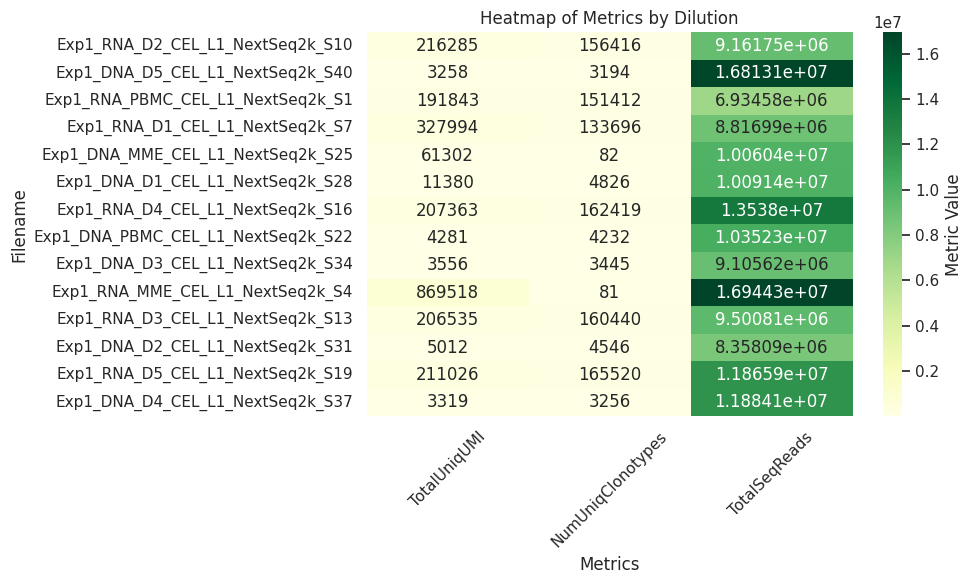

Heatmap for single-repeat saved successfully.


In [10]:
def process_nested_folders(root_folder):
    """
    Recursively traverse nested folders and process each separately.
    """
    for folder_path, subdirs, files in os.walk(root_folder):
        if any(file.endswith(".tsv") for file in files):  # Process folders containing .tsv files
            folder_name = os.path.basename(folder_path)
            print(f"Processing folder: {folder_name}")

            # Generate output file names based on the folder name
            output_file = os.path.join(folder_path, f"{folder_name}_reads_clonotypes_umi.csv")
            
            # Process the folder and generate the CSV file
            result_csv = process_mixture_files(folder_path)
            
            # Plot heatmap if the result CSV is generated successfully
            if result_csv:
                plot_heatmap(result_csv)  # Generates the heatmap using the processed CSV
                print(f"Heatmap for {folder_name} saved successfully.")


# Define the root folder
root_folder = "/home/rittika/Workprojects/Cellecta-results/align-reports/Pool4/single-repeat"  # Replace with the path to your root folder

# Call the function to process nested folders
process_nested_folders(root_folder)